In [45]:
import monai.transforms as MT
from monai.transforms import (
    AddChanneld,
    LoadImage,
    LoadImaged,
    Orientationd,
    Rand3DElasticd,
    RandAffined,
    Spacingd,
    NormalizeIntensityd,
    EnsureChannelFirstd,
    AsChannelFirstd,
    AsChannelLastd,

    ScaleIntensityRanged,
    ScaleIntensityd
)
from monai.config import print_config
from monai.apps import download_and_extract
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

## LoadImaged
## Orientationd
$$ Spacingd


## 普通变换和字典变换的联系与区别
* 普通变换又可以说是基于数组的变换：image和label是以数组形式给到Dataset。字典变换是基于字典的变换（image和label是一个字典对)。
* 普通变换和字典变换的功能是一样的，只是字典变换在每个transform后面都加了一个"d", 也可以写成”D“。如LoadImage/LoadImaged, Resize/Resized
* 使用字典变换时，必须指明该变换是对image做，还是label做。如，LoadImaged（keys='image'）,表明只加载image

In [46]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(f"root dir is: {root_dir}")
data_dir = os.path.join(root_dir,"Task09_Spleen")
print(f"data dir is:{data_dir}")

root dir is: /home/xindong/project/data
data dir is:/home/xindong/project/data/Task09_Spleen


In [47]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images[:4], train_labels[:4])
]
train_data_dicts, val_data_dicts = data_dicts[:2], data_dicts[-2:]

In [48]:
for tdata,vdata in train_data_dicts,val_data_dicts:
    print(tdata)
    print(vdata)

{'image': '/home/xindong/project/data/Task09_Spleen/imagesTr/spleen_10.nii.gz', 'label': '/home/xindong/project/data/Task09_Spleen/labelsTr/spleen_10.nii.gz'}
{'image': '/home/xindong/project/data/Task09_Spleen/imagesTr/spleen_12.nii.gz', 'label': '/home/xindong/project/data/Task09_Spleen/labelsTr/spleen_12.nii.gz'}
{'image': '/home/xindong/project/data/Task09_Spleen/imagesTr/spleen_13.nii.gz', 'label': '/home/xindong/project/data/Task09_Spleen/labelsTr/spleen_13.nii.gz'}
{'image': '/home/xindong/project/data/Task09_Spleen/imagesTr/spleen_14.nii.gz', 'label': '/home/xindong/project/data/Task09_Spleen/labelsTr/spleen_14.nii.gz'}


## 加载NIfTI 格式的文件[LoadImage/ LoadImaged]

MONAI的一个设计选择是，它不仅提供高级工作流组件，而且以最小的功能形式提供相对较低级别的api。

LoadImage类是底层Nibabel映像加载器的简单可调用包装器在使用一些必要的系统参数构造加载程序之后，使用NIfTI文件名调用加载程序实例将返回图像数据数组以及元数据，

例如仿射信息和体素大小。简单说就是，如果是nii.gz格式的文件，调用LoadImage，它会自动调用Nibabel来打开数据。在python中，nii.gz一般都是通过Nibabel来打开的。

LoadImage/ LoadImaged在使用时会有细小的差别，通过举例来说明。

### 注意注意

如果这些变换不是在Compose里面进行组合使用，单独调用时都是需要先实例化的

In [49]:
loader = LoadImaged(keys=("image", "label"))  
data_dict = loader(train_data_dicts[0])
print(f"image shape: {data_dict['image'].shape}")
print(f"label shape: {data_dict['label'].shape}")
print("max pixel val:{}".format(data_dict["image"].max()))
print("min pixel val:{}".format(data_dict["image"].min()))
print(f"image pixdim:\n{data_dict['image_meta_dict']['pixdim'][2]}")
print(f"image dim:\n{data_dict['image_meta_dict']['dim']}")
print(f"data_dict keys:{data_dict.keys()}")
print(f"data_dict img_meta_dict :{data_dict['image_meta_dict'].keys()}\n")
print(f"data_dict img_meta_dict :{data_dict['image_meta_dict'].values()}\n")

image shape: (512, 512, 55)
label shape: (512, 512, 55)
max pixel val:3072.0
min pixel val:-1024.0
image pixdim:
0.9765620231628418
image dim:
[  3 512 512  55   1   1   1   1]
data_dict keys:dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
data_dict img_meta_dict :dict_keys(['sizeof_hdr', 'extents', 'session_error', 'dim_info', 'dim', 'intent_p1', 'intent_p2', 'intent_p3', 'intent_code', 'datatype', 'bitpix', 'slice_start', 'pixdim', 'vox_offset', 'scl_slope', 'scl_inter', 'slice_end', 'slice_code', 'xyzt_units', 'cal_max', 'cal_min', 'slice_duration', 'toffset', 'glmax', 'glmin', 'qform_code', 'sform_code', 'quatern_b', 'quatern_c', 'quatern_d', 'qoffset_x', 'qoffset_y', 'qoffset_z', 'srow_x', 'srow_y', 'srow_z', 'affine', 'original_affine', 'as_closest_canonical', 'spatial_shape', 'original_channel_dim', 'filename_or_obj'])

data_dict img_meta_dict :dict_values([array(348, dtype=int32), array(0, dtype=int32), array(0, dtype=int16), array(0, dtype=uint8), array([  

LoadImaged是会加载图像数据和元数据的,我们打印data_dict.keys() =dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict']) 里面包含了image和label的图像数据索引key，元数据索引key

元数据的key默认保存在{key_meta_dict}中，例如上图中的image的元数据的key 是 image_meta_dict,label的元数据key是label_meta_dict

我们可以根据data_dict['image_meta_dict']中的key来获取元数据信息

例如data_dict['image_meta_dict']['filename_or_obj'] 中保存了Image的url

data_dict['image_meta_dict']['pixdim'] 保存了图像的体素维度信息，等等


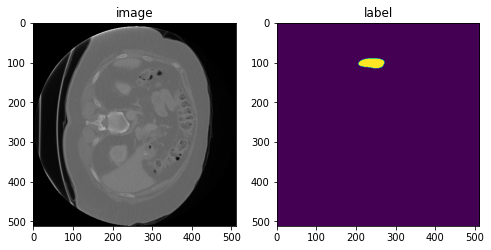

In [50]:
image, label = data_dict["image"], data_dict["label"]
plt.figure("visualize", (8, 4))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:,:,24], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:,:,24])
plt.show()

In [51]:
x = image[:,:,24]
print(x.shape)
print(f"NormalizeIntensityd befor min val:{data_dict['image'].min()}")
print(f"NormalizeIntensityd befor max val:{data_dict['image'].max()}")

(512, 512)
NormalizeIntensityd befor min val:-1024.0
NormalizeIntensityd befor max val:3072.0


In [52]:
orientation = Orientationd(keys=["image", "label"], axcodes="LPS")
print(f"image affine before Orientationd:\n{data_dict['image_meta_dict']['affine']}")
print(f"label affine before Orientationd:\n{data_dict['label_meta_dict']['affine']}")
data_dict_orn = orientation(data_dict)
print(f"image affine after Orientationd:\n{data_dict_orn['image_meta_dict']['affine']}")
print(f"label affine after Orientationd:\n{data_dict_orn['label_meta_dict']['affine']}")

print(f"NormalizeIntensityd befor min val:{data_dict['image'].min()}")
print(f"NormalizeIntensityd befor max val:{data_dict['image'].max()}")


image affine before Orientationd:
[[   0.97656202    0.            0.         -499.02319336]
 [   0.            0.97656202    0.         -499.02319336]
 [   0.            0.            5.            0.        ]
 [   0.            0.            0.            1.        ]]
label affine before Orientationd:
[[   0.97656202    0.            0.         -499.02319336]
 [   0.            0.97656202    0.         -499.02319336]
 [   0.            0.            5.            0.        ]
 [   0.            0.            0.            1.        ]]
image affine after Orientationd:
[[-9.76562023e-01  0.00000000e+00  0.00000000e+00  4.76837158e-07]
 [ 0.00000000e+00 -9.76562023e-01  0.00000000e+00 -4.46288844e+02]
 [ 0.00000000e+00  0.00000000e+00  5.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
label affine after Orientationd:
[[-9.76562023e-01  0.00000000e+00  0.00000000e+00  4.76837158e-07]
 [ 0.00000000e+00 -9.76562023e-01  0.00000000e+00 -4.462

对图像进行一个方向变换，图像默认的方向是RAS坐标表示，如上图，进行了一个LPS的转换

axcodes 指定一个一个轴向默认是"RAS"

as_closest_canonical 如果为 True，则加载最接近规范轴格式的图像。 并忽略axcodes的参数

## 分辨率变换 [Spacingd]

In [53]:
spacing = Spacingd(keys=["image","label"], 
    pixdim=(1.5, 1.5, 5.0), mode=("bilinear", "nearest"))
print(f"label affine before Spacingd:\n{data_dict['label_meta_dict']['affine']}")
data_dict_spa = spacing(data_dict)
print(f"image affine after Spacingd:\n{data_dict_spa['image_meta_dict']['affine']}")


label affine before Spacingd:
[[-9.76562023e-01  0.00000000e+00  0.00000000e+00  4.76837158e-07]
 [ 0.00000000e+00 -9.76562023e-01  0.00000000e+00 -4.46288844e+02]
 [ 0.00000000e+00  0.00000000e+00  5.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
image affine after Spacingd:
[[-1.50000000e+00  0.00000000e+00  0.00000000e+00  4.76837158e-07]
 [ 0.00000000e+00 -1.50000000e+00  0.00000000e+00 -4.46288844e+02]
 [ 0.00000000e+00  0.00000000e+00  5.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


 ## 添加通道 [AddChanneld/EnsureChannelFirstd/AsChannelFirstd/AsChannelLastd]

 ### AddChanneld 
 * 向输入图像添加一个长度为 1 的通道维度。
 * 大多数图像变换假设输入图像采用通道优先格式，其形状为 (num_channels, spatial_dim_1[, spatial_dim_2, …]).monai.transforms

 ### EnsureChannelFirstd 
 * 自动添加一个通道的维度确保通道在shape中的第一位置

 ### AsChannelFirstd 
  * 将图像的通道维度更改为第一维度。 

 ### AsChannelLastd 
 * 将图像的通道维度更改为最后一个维度。 参数channel_dim指定哪个维度改为最后一个维度，默认第一个维度(channel_dim=0)



In [54]:
print(f"AddChanneld before image shape: {data_dict['image'].shape}")
add_channel = AddChanneld(keys=["image", "label"])
data_dict_addc = add_channel(data_dict)
print(f"AddChanneld after image shape: {data_dict_addc['image'].shape}")

print(f"NormalizeIntensityd befor min val:{data_dict['image'].min()}")
print(f"NormalizeIntensityd befor max val:{data_dict['image'].max()}")

AddChanneld before image shape: (512, 512, 55)
AddChanneld after image shape: (1, 512, 512, 55)
NormalizeIntensityd befor min val:-1024.0
NormalizeIntensityd befor max val:3072.0


In [55]:
print(f"EnsureChannelFirstd before image shape: {data_dict['image'].shape}")
firstchannel = EnsureChannelFirstd(keys=["image", "label"])
datac_dict_first = firstchannel(data_dict)
print(f"EnsureChannelFirstd after image shape: {datac_dict_first['image'].shape}")


print(f"NormalizeIntensityd befor min val:{data_dict['image'].min()}")
print(f"NormalizeIntensityd befor max val:{data_dict['image'].max()}")


EnsureChannelFirstd before image shape: (512, 512, 55)
EnsureChannelFirstd after image shape: (1, 512, 512, 55)
NormalizeIntensityd befor min val:-1024.0
NormalizeIntensityd befor max val:3072.0


In [56]:
print(f"AsChannelFirstd before image shape: {data_dict['image'].shape}")
aschannelf = AsChannelFirstd(keys=["image", "label"])
data_dict_asf = aschannelf(data_dict)
print(f"AsChannelFirstd after image shape: {data_dict_asf['image'].shape}")

print(f"NormalizeIntensityd befor min val:{data_dict['image'].min()}")
print(f"NormalizeIntensityd befor max val:{data_dict['image'].max()}")

AsChannelFirstd before image shape: (512, 512, 55)
AsChannelFirstd after image shape: (55, 512, 512)
NormalizeIntensityd befor min val:-1024.0
NormalizeIntensityd befor max val:3072.0


In [57]:
print(f"AsChannelLastd before image shape: {data_dict['image'].shape}")
lastchannel = AsChannelLastd(keys=["image", "label"],channel_dim=0)
data_dict_last = lastchannel(data_dict)
print(f"AsChannelLastd after image shape: {data_dict_last['image'].shape}")

print(f"NormalizeIntensityd befor min val:{data_dict['image'].min()}")
print(f"NormalizeIntensityd befor max val:{data_dict['image'].max()}")

AsChannelLastd before image shape: (512, 512, 55)
AsChannelLastd after image shape: (512, 55, 512)
NormalizeIntensityd befor min val:-1024.0
NormalizeIntensityd befor max val:3072.0


## 强度变换 [NormalizeIntensityd / ScaleIntensityRanged/ScaleIntensityd]

### NormalizeIntensityd
#### 查看源码发现，该函数使用的归一化方法是  image-subtrahend/divisor
#### 参 数 介 绍

* subtrahend：被减数， 可以自己指定，默认为整个图像的均值。

* divisor： 除数， 可以自己指定，默认为整个图像的标准差。

* nonzero(bool)：  等于True,表示只对图像的非0区域做归一化。

* channel_wise(bool)： 当不指定subtrahend和divisor，为True, 表示在每个通道上进行计算均值和标准差，为False,则在整个图像上计算均值和标准差


In [58]:
norm = NormalizeIntensityd(keys='image',nonzero=False)
print(f"NormalizeIntensityd befor min val:{data_dict['image'].min()}")
print(f"NormalizeIntensityd befor max val:{data_dict['image'].max()}")

data_dict_norm = norm(data_dict)

print(f"NormalizeIntensityd after min val:{data_dict['image'].min()}")
print(f"NormalizeIntensityd after max val:{data_dict['image'].max()}")

NormalizeIntensityd befor min val:-1024.0
NormalizeIntensityd befor max val:3072.0
NormalizeIntensityd after min val:-1.1914026737213135
NormalizeIntensityd after max val:7.314192771911621


### ScaleIntensityd
* 将输入图像的强度缩放到给定的值范围 (minv, maxv)。如果未提供 minv 和 maxv，则使用因子按 v = v * (1 + 因子) 缩放图像。
* minv 默认为 0
* maxv 默认为 1 

In [59]:
scaleInten = ScaleIntensityd(keys='image')
data_dict_s = scaleInten(data_dict)

print(f"NormalizeIntensityd befor min val:{data_dict['image'].min()}")
print(f"NormalizeIntensityd befor max val:{data_dict['image'].max()}")

print(f"NormalizeIntensityd after min val:{data_dict_s['image'].min()}")
print(f"NormalizeIntensityd after max val:{data_dict_s['image'].max()}")

NormalizeIntensityd befor min val:-1.1914026737213135
NormalizeIntensityd befor max val:7.314192771911621
NormalizeIntensityd after min val:0.0
NormalizeIntensityd after max val:1.0


###  ScaleIntensityRanged和NormalizeIntensityd不同之处在于， ScaleIntensityRanged可以指定把哪些范围值缩放到那个区间。

比如对脾脏的分割中，我们只在于脾脏的CT值范围（假设在-300-- +300之间），而骨头等高强度的信号（大于2000）我们不需要。如果直

接将这个强度进行归一化，脾脏内部的值范围就很小。我们就可以直接把脾脏的CT值范围 [-300,+300] 进行归一化到 [0, 1], 而不在

[-300,+300] 这中间的值都为0。事实上，很多论文都是这样做的。

#### 参 数 介 绍

a_min：float，强度原始范围最小值。可以理解为需要被归一化的最小值，如我们这个例子中的-300(需要写成小数，-300.0)

a_max： float， 强度原始范围最大值。可以理解为需要被归一化的最大值，如我们这个例子中的300(需要写成小数，300.0)

b_min： float,  强度目标范围最小值。可以理解为归一化后的最小值，通常设置为0.0

b_max： float,  强度目标范围最大值。可以理解为归一化后的最大值，通常设置为1.0

clip： 布尔值。设置为True, 才会把[-300,+300]之外的值都设置为0.通常为True


In [66]:
scaleRange = ScaleIntensityRanged(keys='image', a_min=-300.0, a_max=300.0, b_min=0.0, b_max=1.0, clip=True)
 
# 由于上面我们把datac_dict归一化了，因此，我们要重新制造一个datac_dict
data_dict1 = loader(train_data_dicts[1])
datac_dict1_ad = add_channel(data_dict1)
data_dict_sr = scaleRange(datac_dict1_ad)
print(data_dict_sr['image'].shape)
print('original max value', data_dict1['image'].max())
print('original min value', data_dict1['image'].min())
print('target max value', data_dict_sr['image'].max())


(1, 512, 512, 168)
original max value 3072.0
original min value -1024.0
target max value 1.0


## 空间变换 [Rotate90d / Resized]

### 注意注意

使用旋转，尤其是随机旋转的时候一定要注意，如果是分割，image和label应当一同旋转，并且旋转方式要一模一样。

In [70]:
from monai.transforms import RandRotate90d, Resized
print(data_dict_sr['image'].shape)
rotate = RandRotate90d(keys=['image', 'label'], prob=0.5, max_k=1, spatial_axes=(2,1))
data_rotate = rotate(data_dict_sr)
print(data_rotate['image'].shape)
print(data_rotate['label'].shape)

(1, 512, 512, 168)
(1, 512, 168, 512)
(1, 512, 168, 512)


### Resized
参 数 介 绍

spatial_size: 序列[int, int,], 期大小调整操作之后的空间尺寸的形状

mode: resize使用的插值方式，默认为”area, “可以选择"nearest", "linear", "bilinear", "bicubic", "trilinear"

In [72]:
resize = Resized(keys=['image', 'label'], spatial_size=(256,256,256))
data_dict_resize = resize(data_rotate)
print(data_dict_resize['image'].shape)
 
# (1, 256, 256, 256)

(1, 256, 256, 256)
